In [366]:
using QuantumStates
using UnitsToValue

### Load $X(01^10)$ Hamiltonian

In [381]:
H0 = load_from_file("CaOH_X000", "C://Google Drive//github//QuantumStates//Hamiltonians//CaOH//")
;

In [368]:
H0 = load_from_file("CaOH_X010", "C://Google Drive//github//QuantumStates//Hamiltonians//CaOH//")
;

In [382]:
const μX = 1e-6 * 1.458 * (1e-21 / c) / h;

In [383]:
import QuantumStates: polarizability, Zeeman

w = 25e-6; P = 13.25; I_trap = 2P / (π * w^2);
const α = [3.37471e-39, 0, -1.01809e-39] # 1064 nm
const θ = 0 * (π / 2)
const ϵ_trap = cos(θ) * [0.0, 1.0, 0.0] + sin(θ) * [1.0, 0.0, -1.0] / √2
polarizability(state, state′) = polarizability(state, state′, α, ϵ_trap)
# @time H = add_to_H(H0, :I_trap, (1e-6 / h) * polarizability)

@time H = add_to_H(H0, :E, (1e2 * μX) * Stark) # 1e2 converts from V/m to V/cm

# const B_x = [1.0, 0.0, -1.0] ./ √2
# const B_z = [0.0, 1.0, 0.0]
# Zeeman_x(state, state′) = (1/√2)  * (Zeeman(state, state′, -1) - Zeeman(state, state′, +1))
# Zeeman_y(state, state′) = (im/√2) * (Zeeman(state, state′, -1) + Zeeman(state, state′, +1))
Zeeman_z(state, state′) = Zeeman(state, state′, 0)
# H = add_to_H(H, :B_x, gS * μ_B * Zeeman_x)
# H = add_to_H(H, :B_y, gS * μ_B * Zeeman_y)
# H = add_to_H(H, :B_z, gS * μ_B * Zeeman_z)
H = add_to_H(H, :B_z, 0.01 * Zeeman_z)

# H.parameters.I_trap = (1.0 / 3.5) * I_trap / (2ε_0 * c)
H.parameters.E = 500. #198 * 0.3
# H.parameters.B_x = 0.0
H.parameters.B_z = 1e-6

@time full_evaluate!(H)
@time solve!(H)
;

  0.123595 seconds (52.68 k allocations: 3.588 MiB, 97.54% compilation time)


  0.282715 seconds (142.67 k allocations: 9.891 MiB, 10.27% gc time, 88.29% compilation time)
  0.019041 seconds (10.62 k allocations: 990.647 KiB, 88.53% compilation time)


### Plot trap intensity dependence

In [384]:
I_trap_scan_range = (0:0.02:1) .* I_trap / (2ε0 * c)
x = scan_single_parameter(deepcopy(H), :I_trap, I_trap_scan_range);

LoadError: UndefVarError: `ε0` not defined

In [385]:
plot_values = zeros(length(I_trap_scan_range), length(H.states))
for (i, I_trap_value) ∈ enumerate(sort(collect(keys(x.state_dict))))
    plot_values[i,:] = energy.(x.state_dict[I_trap_value])
end

LoadError: UndefVarError: `I_trap_scan_range` not defined

In [386]:
plot(I_trap_scan_range, plot_values[:,1:24], legend=nothing)

LoadError: UndefVarError: `plot_values` not defined

### Electric field scan

In [387]:
using LaTeXStrings

In [388]:
function H_func!(H, scan_values)
    H.parameters.E = scan_values[1]
    evaluate!(H)
    QuantumStates.solve!(H)
    return nothing
end
;

In [389]:
Es = 0:2.:500
# Es = exp.(0:0.05:15)
scan_params = (
    E = Es,
    );
iterator = Iterators.product
@time scan_values, _ = scan_parameters(deepcopy(H), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=1)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  1.233724 seconds (241.74 k allocations: 97.822 MiB, 2.23% gc time, 28.65% compilation time)


In [390]:
matrix_values = hcat(values(scan_values)...)';

In [391]:
matrix_values_bending = hcat(values(scan_values)...)';

In [392]:
energy.(H.states)[1:24]

24-element Vector{Float64}:
    -4.190814259023901
    -1.5888692373820326
    -1.5887926222708315
    -1.5887926122602678
 20011.2946039886
 20011.294603992606
 20011.312970443545
 20011.3712336902
 20062.10319330036
 20062.10319330999
 20063.206021766095
 20063.411910348143
 20063.411910358212
 20064.591328721843
 20064.591328726063
 20064.77141455321
 60085.51424515482
 60085.514245161015
 60085.759636160015
 60085.759636164854
 60085.96780860302
 60086.24115913156
 60086.241159134974
 60086.48260192414

In [397]:
function differences_derivative(xs, ys)
    ys_diff = ys[2:end,:] .- ys[1:end-1,:]
    xs_diff = xs[2:end] - xs[1:end-1]
    return ys_diff ./ xs_diff
end; 

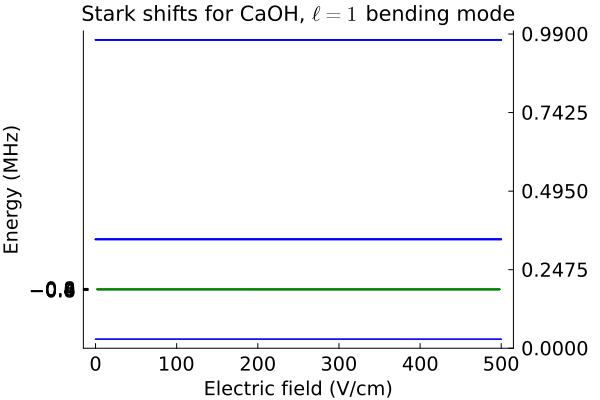

In [398]:
using Plots
using Plots.PlotMeasures
xs = collect(Es)
ys = matrix_values[:,1:24] .- 10000
plot(xs[1:end-1][2:end], differences_derivative(xs, ys)[2:end,:] .* 1.458^2, linewidth=1.5, linecolor=:green, alpha=0.3)
plot!(xs, ys ./ 250, linewidth=1.5, linecolor=:blue, alpha=0.5)
plot!(
    legend=nothing, 
    # size=(1400,700),
    xlabel="Electric field (V/cm)",
    ylabel="Energy (MHz)",
    labelfontsize=13,
    tickfontsize=13,
    grid=:off,
    box=:on,
    # ylim=(-250,250),
    title=L"Stark shifts for CaOH, $\ell = 1$ bending mode",
    yticks=-0.8:0.4:0.8
    )
plot!(twinx(),color=:red,xticks=:none,label="right",yticks=0.0:0.99/4:0.99,tickfontsize=13)

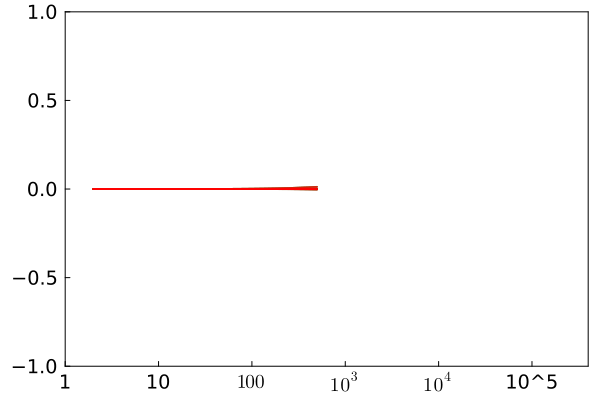

In [399]:
using Plots
using Plots.PlotMeasures
xs = collect(Es)
ys = matrix_values[:,1:24]
ys1 = matrix_values_bending[:,1:24];
plot(xs[1:end-1][2:end], -differences_derivative(xs, ys1)[2:end,:] .* 1.458, linewidth=1.5, linecolor=:green, alpha=0.3)
plot!(xs[1:end-1][2:end], -differences_derivative(xs, ys)[2:end,:] .* 1.458, linewidth=1.5, linecolor=:red, alpha=0.3)
# plot!(xs, ys ./ 450000, linewidth=1.5, linecolor=:blue, alpha=0.5)
plot!(
    legend=nothing, 
    # size=(1400,700),
    labelfontsize=13,
    tickfontsize=13,
    xlim=(1,400000),
    grid=:off,
    box=:on,
    ylim=(-1,1),
    # ylim=(-250,250),
    xaxis=:log,
    xticks=(exp10.(0:6), ["1","10",L"100",L"10^3",L"10^4","10^5","10^6"])
    )

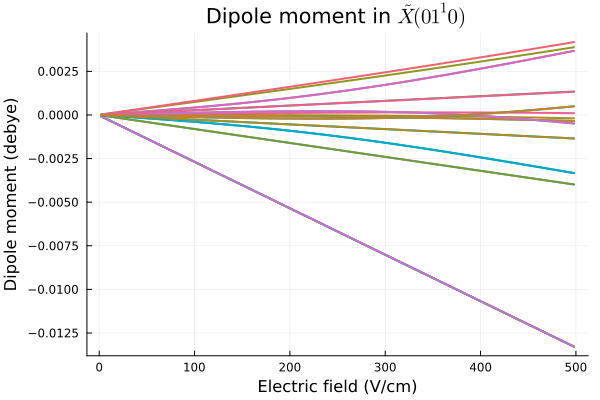

In [400]:
using Plots
plot(xs[1:end-1][2:end], differences_derivative(xs, ys)[2:end,:] * 1.486, linewidth=2)
plot!(
    legend=nothing, 
    # size=(1400,700),
    xlabel="Electric field (V/cm)",
    ylabel="Dipole moment (debye)",
    title=L"Dipole moment in $\widetilde{X}(01^10)$"
    )

### Decoupled basis

In [450]:
H.parameters.E = 50000000.0
H.parameters.B_z = 0.0
evaluate!(H); solve!(H);

In [451]:
# QN_bounds = (S = 1/2, I = 1/2, Λ = [-1,1], N = 1:3)
QN_bounds = (S = 1/2, I = 1/2, Λ = 0, N = 1:3)
basis_decoupled = enumerate_states(HundsCaseB_Decoupled, QN_bounds)
states_decoupled = convert_basis(H.states, basis_decoupled)
;

In [466]:
states_decoupled[5]

State{HundsCaseB_Decoupled}(-2.395819627150413e7, HundsCaseB_Decoupled[HundsCaseB_Decoupled(0.0, 0, 1, -1, 1/2, -1/2, 1/2, -1/2, (N = 0:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, 0, 1, -1, 1/2, -1/2, 1/2, 1/2, (N = 0:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, 0, 1, -1, 1/2, 1/2, 1/2, -1/2, (N = 0:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, 0, 1, -1, 1/2, 1/2, 1/2, 1/2, (N = 0:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, 0, 1, 0, 1/2, -1/2, 1/2, -1/2, (N = 0:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, 0, 1, 0, 1/2, -1/2, 1/2, 1/2, (N = 0:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, 0, 1, 0, 1/2, 1/2, 1/2, -1/2, (N = 0:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, 0, 1, 0, 1/2, 1/2, 1/2, 1/2, (N = 0:∞, M_N = -1:1, M_S = -

In [459]:
H.states[4]

State{HundsCaseB_Rot}(-3.1561691471602987e7, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 3/2, 1, -1, (N =

In [464]:
energy.(states_decoupled)[1:24]

24-element Vector{Float64}:
 -3.156169429775286e7
 -3.1561692144052427e7
 -3.156169147160299e7
 -3.1561691471602987e7
 -2.395819627150413e7
 -2.3958196271504108e7
 -2.395819502592397e7
 -2.3958194504258864e7
 -2.3958161426945046e7
 -2.395816142694502e7
 -2.3958160006023068e7
 -2.3958160006023e7
 -1.3780669760558771e7
 -1.378066976055876e7
 -1.3780668531324314e7
 -1.3780668531324279e7
 -1.37806001896979e7
 -1.3780600189697882e7
 -1.3780599012876503e7
 -1.3780599012876494e7
 -1.2417598025907574e7
 -1.2417595485290585e7
 -1.2417595485290572e7
 -1.24175953011413e7

In [465]:
states_decoupled[9]

State{HundsCaseB_Decoupled}(-2.3958161426945046e7, HundsCaseB_Decoupled[HundsCaseB_Decoupled(0.0, 0, 1, -1, 1/2, -1/2, 1/2, -1/2, (N = 0:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, 0, 1, -1, 1/2, -1/2, 1/2, 1/2, (N = 0:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, 0, 1, -1, 1/2, 1/2, 1/2, -1/2, (N = 0:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, 0, 1, -1, 1/2, 1/2, 1/2, 1/2, (N = 0:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, 0, 1, 0, 1/2, -1/2, 1/2, -1/2, (N = 0:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, 0, 1, 0, 1/2, -1/2, 1/2, 1/2, (N = 0:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, 0, 1, 0, 1/2, 1/2, 1/2, -1/2, (N = 0:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, 0, 1, 0, 1/2, 1/2, 1/2, 1/2, (N = 0:∞, M_N = -1:1, M_S = 

In [316]:
states_decoupled[2]

State{HundsCaseB_Decoupled}(7715.472335643785, HundsCaseB_Decoupled[HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, -1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, -1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, 1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, 1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, -1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, -1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, 1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, 1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_

In [311]:
states_decoupled[3]

State{HundsCaseB_Decoupled}(7716.957202003799, HundsCaseB_Decoupled[HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, -1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, -1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, 1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, 1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, -1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, -1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, 1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, 1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_

In [312]:
states_decoupled[4]

State{HundsCaseB_Decoupled}(7716.961324025382, HundsCaseB_Decoupled[HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, -1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, -1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, 1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, -1, 1/2, 1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, -1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, -1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, 1/2, 1/2, -1/2, (N = 1:∞, M_N = -1:1, M_S = -0.5:1.0:0.5, M_I = -0.5:1.0:0.5)), HundsCaseB_Decoupled(0.0, -1, 1, 0, 1/2, 1/2, 1/2, 1/2, (N = 1:∞, M_N = -1:1, M_

In [22]:
expectation(states_decoupled[subspace(H.states, (N=1,))[1][14]], :M_S)

0.005600369479115385 + 0.0im

In this basis, the first-order Stark shifts are given by the product $\Lambda M_N$:

In [23]:
idxs = subspace(states_decoupled, (M_N = 0,))[1];

### Magnetic field scan

In [24]:
using Plots.PlotMeasures

In [114]:
H.parameters

ParameterList(Dict(:B_y => 0.0, :cX => 2.053, :I_trap => 7.26354298635441e11, :DX => 0.0117818435994, :BX => 9996.819345976399, :B_z => 0.00101, :γX => 35.4954270272, :B_x => 0.0, :qX => 21.52809640898, :bFX => 2.602…))

In [45]:
H.parameters.E = 0.0
evaluate!(H) 
solve!(H)
states_idxs = subspace(H.states, (N=1,))[1]
;

In [57]:
Es = 0.0:0.1:65
g_factors = scan_single_parameter_gfactor(H, :E, Es);

In [88]:
Es[600] / 0.3

199.66666666666666

In [92]:
g_factors[600,14]

6.96036295266822e-8

In [111]:
g_factors[645,19]

-1.0757503332570195e-7

In [113]:
Es[645] / 0.3

214.66666666666669

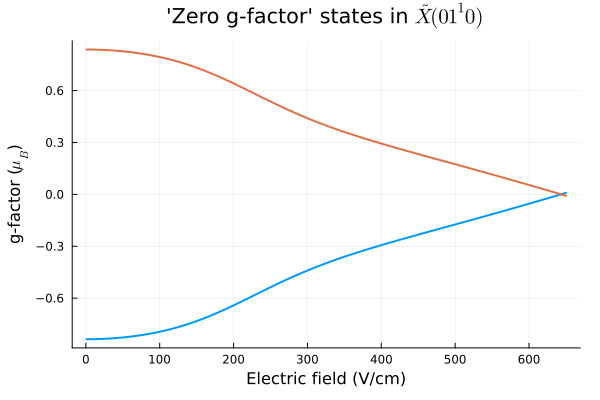

In [95]:
plot(g_factors[2:end, states_idxs[18:19]] ./ maximum(g_factors), linewidth=2)
plot!(
    legend=nothing,
    xlabel="Electric field (V/cm)",
    ylabel=L"g-factor ($\mu_B$)",
    title=L"'Zero g-factor' states in $\widetilde{X}(01^10)$",
    margin=3mm
    )

### Plot $\langle \Sigma \rangle$ versus electric field E

In [20]:
H.parameters.E = 0.0
H.parameters.B = 0.0
evaluate!(H)
solve!(H)

In [21]:
plot_values = zeros(length(E_scan_range), length(H.states))
for (i, E_value) ∈ enumerate(sort(collect(keys(x.state_dict))))
    plot_values[i,:] = Σ.(x.state_dict[E_value])
end

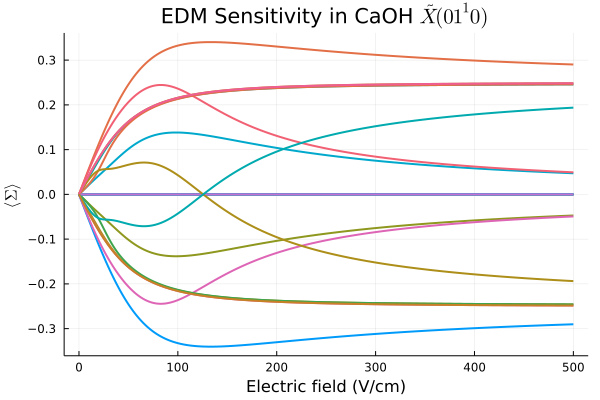

In [22]:
xs = collect(E_scan_range)
ys = plot_values[:,1:24]
plot(xs, ys, linewidth=2)
plot!(
    legend=nothing,
    # size=(1400,700),
    xlabel="Electric field (V/cm)",
    ylabel=L"\langle \Sigma \rangle",
    title=L"EDM Sensitivity in CaOH $\widetilde{X}(01^10)$"
    )